In [3]:
import nlp_utils
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing

In [2]:
# Load parsed news dataset
dataset = nlp_utils.NewsTextDataset()
dataset.load("/home/alexander/HSE_Stuff/NLP-Course/datasets/final_dataset_4k.json")

In [3]:
# Before preprocessing
dataset[0].text

'Сооснователь и в прошлом многолетний руководитель Microsoft Билл Гейтс стал крупнейшим частным владельцем сельскохозяйственных угодий в США, пишет российское издание журнала Forbes со ссылкой на The Land Report.\nГейтс скупал сельскохозяйственные угодья на протяжении нескольких лет, и сейчас ему принадлежат участки в 19 штатах, подсчитало издание. Крупнейшие расположены в Луизиане (280 кв. км), Арканзасе (194 кв. км) и Небраске (83 кв. км). Земли напрямую или опосредованно принадлежат Cascade Investments - инвестиционному фонду, который инвестирует средства семьи Гейтса, указал The Land Report.\nЧасть участков предприниматель скупает через подконтрольный ему инвестиционный фонд Cascade Investment.\nCascade Investments не ответил на запрос Forbes USA. Как именно используются принадлежащие Гейтсу земли, до конца неясно. Журнал обращает внимание, что "дочка" Cascade Cottonwood Ag Management входит в некоммерческую организацию Leading Harvest, которая выступает за защиту культур, почвы и 

In [4]:
# Preprocessing
dataset.preprocess()

3999it [00:43, 91.88it/s] 


In [15]:
# After preprocessing (only fixe first words)
dataset[0].tokenized_text[:5]

['сооснователь', 'прошлый', 'многолетний', 'руководитель', 'билл']

In [5]:
# We can load & save dataset
dataset.save("/home/alexander/HSE_Stuff/NLP-Course/datasets/final_dataset_4k_tokenized.json")

In [4]:
dataset = nlp_utils.NewsTextDataset()
dataset.load("/home/alexander/HSE_Stuff/NLP-Course/datasets/final_dataset_4k_cleaned.json")

In [5]:
data = dataset.dump_to_pandas()

In [6]:
data

,category,tokenized_text
0,экономика,"[сооснователь, прошлый, многолетний, руководит..."
1,экономика,"[минэкономразвития, дорабатывать, вносить, пра..."
2,экономика,"[счет, который, открывать, российский, граждан..."
3,экономика,"[российский, рубль, являться, самый, недооцени..."
4,экономика,"[российский, онлайн, кинотеатр, откладывать, н..."
...,...,...
3994,спорт,"[нападающий, ска, санкт-петербург, антон, бурд..."
3995,спорт,"[матч, реванш, временный, чемпион, версия, все..."
3996,спорт,"[финский, клуб, йокерит, продолжать, соблюдать..."
3997,спорт,"[против, бывший, футболист, сборная, россия, р..."


In [7]:
data.groupby('category').count()

,tokenized_text
category,
культура,1000
спорт,1000
технологии,1000
экономика,999


In [86]:
classes = data['category'].unique()

In [87]:
classes

array(['экономика', 'культура', 'технологии', 'спорт'], dtype=object)

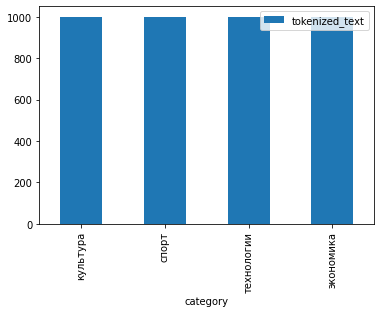

In [8]:
data.groupby('category').count().plot.bar(ylim=0)
plt.show()

In [9]:
def convert_list_to_string(org_list, seperator=' '):
    return seperator.join(org_list)

In [10]:
data['tokenized_text'].apply(convert_list_to_string)

0       сооснователь прошлый многолетний руководитель ...
1       минэкономразвития дорабатывать вносить правите...
2       счет который открывать российский гражданин ко...
3       российский рубль являться самый недооценивать ...
4       российский онлайн кинотеатр откладывать неопре...
                              ...                        
3994    нападающий ска санкт-петербург антон бурдасов ...
3995    матч реванш временный чемпион версия всемирный...
3996    финский клуб йокерит продолжать соблюдать двух...
3997    против бывший футболист сборная россия роман ш...
3998    тель-авив хайфа готовый рассматривать вопрос с...
Name: tokenized_text, Length: 3999, dtype: object

In [11]:
data['tokenized_text'] = data['tokenized_text'].apply(convert_list_to_string)

In [12]:
data

,category,tokenized_text
0,экономика,сооснователь прошлый многолетний руководитель ...
1,экономика,минэкономразвития дорабатывать вносить правите...
2,экономика,счет который открывать российский гражданин ко...
3,экономика,российский рубль являться самый недооценивать ...
4,экономика,российский онлайн кинотеатр откладывать неопре...
...,...,...
3994,спорт,нападающий ска санкт-петербург антон бурдасов ...
3995,спорт,матч реванш временный чемпион версия всемирный...
3996,спорт,финский клуб йокерит продолжать соблюдать двух...
3997,спорт,против бывший футболист сборная россия роман ш...


In [13]:
vectorizer = TfidfVectorizer(min_df= 3, sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(data['tokenized_text'])

In [14]:
final_features.shape

(3999, 69696)

In [15]:
X = data['tokenized_text']
Y = data['category']

In [16]:
Y

0       экономика
1       экономика
2       экономика
3       экономика
4       экономика
          ...    
3994        спорт
3995        спорт
3996        спорт
3997        спорт
3998        спорт
Name: category, Length: 3999, dtype: object

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [18]:
y_test.shape

(800,)

In [22]:
ytest = np.array(y_test)

### Some tests

In [69]:
def custom_tests(model, text=['Спорт полезен для здоровья',
                             'Человек должен разбираться в исскустве',
                             'Будущее за нейросетями!!!',
                             'Когда уже рубль будет расти???']):
    answers = [(label, text) for label, text in zip(model.predict(text), text)]
    return answers

# Classification

In [44]:
from sklearn.linear_model import LinearRegression
linear_reg_clf = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LinearRegression())])

In [45]:
linear_reg_model = pipeline.fit(X_train, y_train)

In [70]:
custom_tests(linear_reg_model)

[('спорт', 'Спорт полезен для здоровья'),
 ('культура', 'Человек должен разбираться в исскустве'),
 ('культура', 'Будущее за нейросетями!!!'),
 ('экономика', 'Когда уже рубль будет расти???')]

              precision    recall  f1-score   support

    культура       0.95      0.95      0.95       214
       спорт       0.99      0.94      0.97       182
  технологии       0.92      0.97      0.94       203
   экономика       0.95      0.96      0.95       201

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



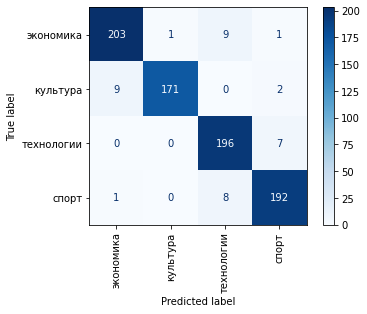

In [100]:
print(classification_report(ytest, linear_reg_model.predict(X_test)))
plot_confusion_matrix(linear_reg_model, X_test, y_test,
                             display_labels=classes,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical')

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LogisticRegression(random_state=42))])

In [73]:
log_reg_model = pipeline.fit(X_train, y_train)


In [72]:
custom_tests(log_reg_model)

[('спорт', 'Спорт полезен для здоровья'),
 ('культура', 'Человек должен разбираться в исскустве'),
 ('культура', 'Будущее за нейросетями!!!'),
 ('экономика', 'Когда уже рубль будет расти???')]

In [21]:
import pickle
with open('models_weights/LogisticRegression.pickle', 'wb') as f:
    pickle.dump(log_reg_model, f)

              precision    recall  f1-score   support

    культура       0.95      0.95      0.95       214
       спорт       0.99      0.94      0.97       182
  технологии       0.92      0.97      0.94       203
   экономика       0.95      0.96      0.95       201

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



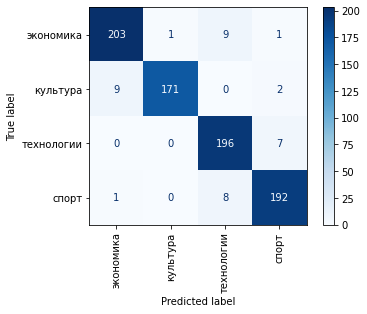

In [99]:
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, log_reg_model.predict(X_test)))
plot_confusion_matrix(log_reg_model, X_test, y_test,
                             display_labels=classes,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical')

### KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', KNeighborsClassifier(n_neighbors=7))])

In [27]:
knn_model = pipeline.fit(X_train, y_train)
import pickle
with open('models_weights/KNN.pickle', 'wb') as f:
    pickle.dump(knn_model, f)

In [74]:
custom_tests(knn_model)

[('спорт', 'Спорт полезен для здоровья'),
 ('культура', 'Человек должен разбираться в исскустве'),
 ('культура', 'Будущее за нейросетями!!!'),
 ('экономика', 'Когда уже рубль будет расти???')]

              precision    recall  f1-score   support

    культура       0.95      0.95      0.95       214
       спорт       0.99      0.94      0.97       182
  технологии       0.92      0.97      0.94       203
   экономика       0.95      0.96      0.95       201

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



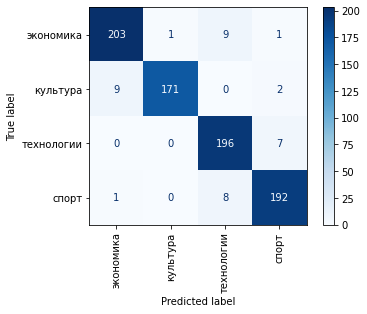

In [98]:
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, knn_model.predict(X_test)))
plot_confusion_matrix(knn_model, X_test, y_test,
                             display_labels=classes,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical')

### SVM

In [30]:
from sklearn.linear_model import SGDClassifier
svm_clf = Pipeline([
    ('vect', vectorizer),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

In [31]:
svm_model = svm_clf.fit(X_train, y_train)
with open('models_weights/SVM.pickle', 'wb') as f:
    pickle.dump(svm_model, f)

In [75]:
custom_tests(svm_model)

[('спорт', 'Спорт полезен для здоровья'),
 ('культура', 'Человек должен разбираться в исскустве'),
 ('спорт', 'Будущее за нейросетями!!!'),
 ('экономика', 'Когда уже рубль будет расти???')]

              precision    recall  f1-score   support

    культура       0.99      0.99      0.99       214
       спорт       0.99      1.00      0.99       182
  технологии       0.99      0.97      0.98       203
   экономика       0.97      0.99      0.98       201

    accuracy                           0.98       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.98      0.98       800



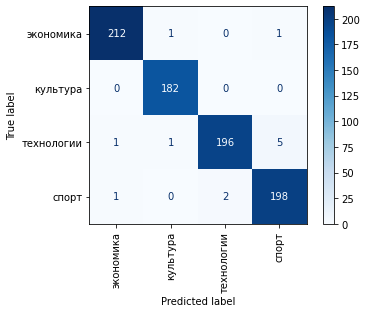

In [97]:
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, svm_model.predict(X_test)))
plot_confusion_matrix(svm_model, X_test, y_test,
                             display_labels=classes,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical')

### Naive Bayes

In [33]:
from sklearn.naive_bayes import MultinomialNB
naive_clf = Pipeline([
    ('vect', vectorizer),
     ('clf', MultinomialNB())
])

In [34]:
nb_model = naive_clf.fit(X_train, y_train)
with open('models_weights/Naive_Bayes.pickle', 'wb') as f:
    pickle.dump(nb_model, f)

In [76]:
custom_tests(nb_model)

[('спорт', 'Спорт полезен для здоровья'),
 ('культура', 'Человек должен разбираться в исскустве'),
 ('технологии', 'Будущее за нейросетями!!!'),
 ('экономика', 'Когда уже рубль будет расти???')]

              precision    recall  f1-score   support

    культура       0.98      0.99      0.98       214
       спорт       0.99      0.97      0.98       182
  технологии       0.98      0.95      0.96       203
   экономика       0.95      0.99      0.97       201

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



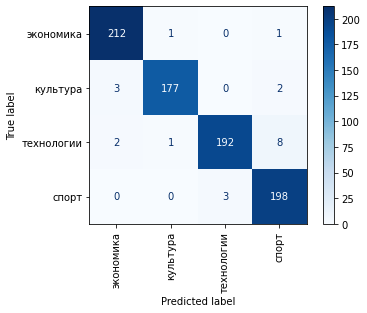

In [96]:
print(classification_report(ytest, nb_model.predict(X_test)))
plot_confusion_matrix(nb_model, X_test, y_test,
                             display_labels=classes,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical')

### Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
radom_forest_clf = Pipeline([
    ('vect', vectorizer),
     ('clf', RandomForestClassifier())
])

In [42]:
radom_forest_model = radom_forest_clf.fit(X_train, y_train)
with open('models_weights/RandomForest.pickle', 'wb') as f:
    pickle.dump(radom_forest_model, f)

In [77]:
custom_tests(radom_forest_model)

[('спорт', 'Спорт полезен для здоровья'),
 ('культура', 'Человек должен разбираться в исскустве'),
 ('спорт', 'Будущее за нейросетями!!!'),
 ('культура', 'Когда уже рубль будет расти???')]

In [93]:
print(classification_report(ytest, radom_forest_model.predict(X_test)))

              precision    recall  f1-score   support

    культура       0.99      0.97      0.98       214
       спорт       0.97      0.99      0.98       182
  технологии       0.98      0.97      0.97       203
   экономика       0.97      0.98      0.97       201

    accuracy                           0.97       800
   macro avg       0.97      0.98      0.98       800
weighted avg       0.98      0.97      0.97       800



In [94]:
from sklearn.metrics import plot_confusion_matrix

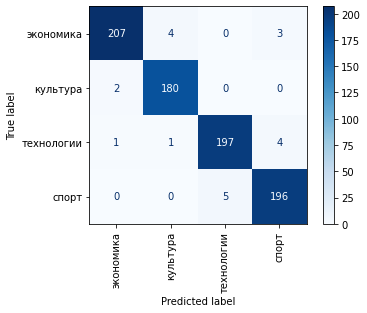

In [95]:
plot_confusion_matrix(radom_forest_model, X_test, y_test,
                             display_labels=classes,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical')

### Let's use Grid Search to achieve better results

In [78]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}

In [83]:
svm_clf_grid = Pipeline([
    ('vect', vectorizer),
    ('clf', SGDClassifier()),
])
gs_clf = GridSearchCV(svm_clf_grid, parameters, cv=5, n_jobs=-1)

In [101]:
## TODO